## Package imports, global variables and functions

In [2]:
import mysql.connector
import json
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 15]

host = "localhost"
un = "root"
pw=""
db_name = "yelp"

def mysql_result_to_df(result, cursor):
    field_names = [i[0] for i in mycursor.description]
    return pd.DataFrame(myresult, columns=field_names)

def df_to_csv(df, fp, ext=".csv", na_rep=""):
    try:
        df.to_csv(fp + ext, encoding="utf-8", header = True,\
            doublequote = True, sep=",", index=False, na_rep=na_rep)
    except Exception as e:
        print("Error: {}".format(str(e)))

fp = "C:/Users/Tolis/Documents/Data Analytics Cource/CKME136 X10/Project/data/final/summary"

## Connect to yelp db and load user table

In [3]:
mydb = mysql.connector.connect(
  host=host,
  user=un,
  passwd=pw,
  database=db_name
)

mycursor = mydb.cursor()

mycursor.execute("SELECT * FROM user")

myresult = mycursor.fetchall()

user_df = mysql_result_to_df(myresult, mycursor)

mycursor.close()
mydb.close()

## Replace blanks as null and transform list column

In [4]:
#Stars gets imported as a string, so convert to decimal
user_df["average_stars"] = user_df["average_stars"].apply(lambda val: float(val))

user_df = user_df.replace(r'^\s*$', np.nan, regex=True)
user_df = user_df.replace(r'^{}*$', np.nan, regex=True)
#Transform list column 'elite' to count
def get_list_count(val):
    if(val==""):
        return 0
    try:
        result = val.split(",")
        return len(result)
    except:
        return np.nan

user_df["elite_count"] = user_df["elite"].apply(get_list_count)

## Numeric summaries

In [5]:
#Description of quantitative fields.
df_description_number = user_df.describe(include=[np.number])
print(df_description_number)

       review_count        useful         funny          cool          fans  \
count  1.637138e+06  1.637138e+06  1.637138e+06  1.637138e+06  1.637138e+06   
mean   2.228770e+01  4.052770e+01  1.791785e+01  2.188046e+01  1.465646e+00   
std    7.692236e+01  4.702421e+02  3.303504e+02  4.019675e+02  1.568317e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    5.000000e+00  3.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.500000e+01  1.300000e+01  3.000000e+00  3.000000e+00  0.000000e+00   
max    1.327800e+04  1.542020e+05  1.302070e+05  1.486580e+05  9.538000e+03   

       average_stars  compliment_hot  compliment_more  compliment_profile  \
count   1.637138e+06    1.637138e+06     1.637138e+06        1.637138e+06   
mean    3.681462e+00    2.242225e+00     3.325951e-01        2.135135e-01   
std     1.151040e+00    8.021821e+01     1.367850e+01    

In [6]:
#Description for qualitative
df_description_cat = user_df.describe(include=[np.object])
print(df_description_cat)

                       user_id     name      elite
count                  1637138  1637138      71377
unique                 1637138   124917        755
top     YB7tZflAd8Aw9bSoARwQXg     John  2017,2018
freq                         1    14430       9316


In [7]:
#Row and col counts.
row_count = user_df.shape[0]
col_count = user_df.shape[1]
print(user_df.shape)

(1637138, 22)


In [8]:
#Summary of NULLS
#Will need to drop fields that have a Null Percent > .5
#I will then fill the remaining null values with their field's average.
null_columns=user_df.columns[user_df.isnull().any()]
df_description_nulls=user_df[null_columns].isnull().sum()
df_description_nulls = pd.DataFrame(df_description_nulls, columns=["Null Count"])
df_description_nulls["Null Percent"] = df_description_nulls["Null Count"].apply(lambda x: x/row_count)
print(df_description_nulls)

             Null Count  Null Percent
elite           1565761      0.956401
elite_count     1565761      0.956401


# Plots

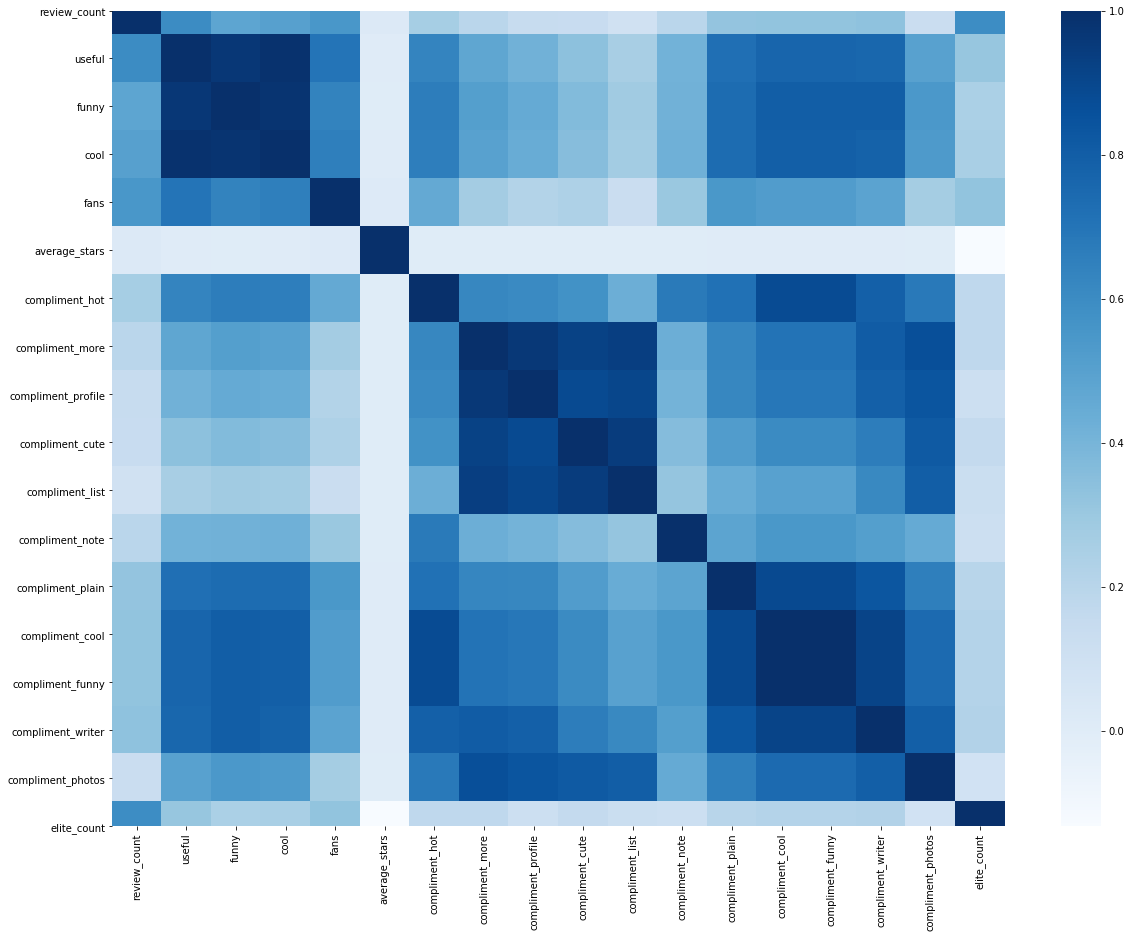

In [9]:
#Visualize correlations between quantitative vars
#variables that are strongly correleated will be removed during the feature selection process.
corr = user_df.corr()
sns.heatmap(corr, cmap="Blues", 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

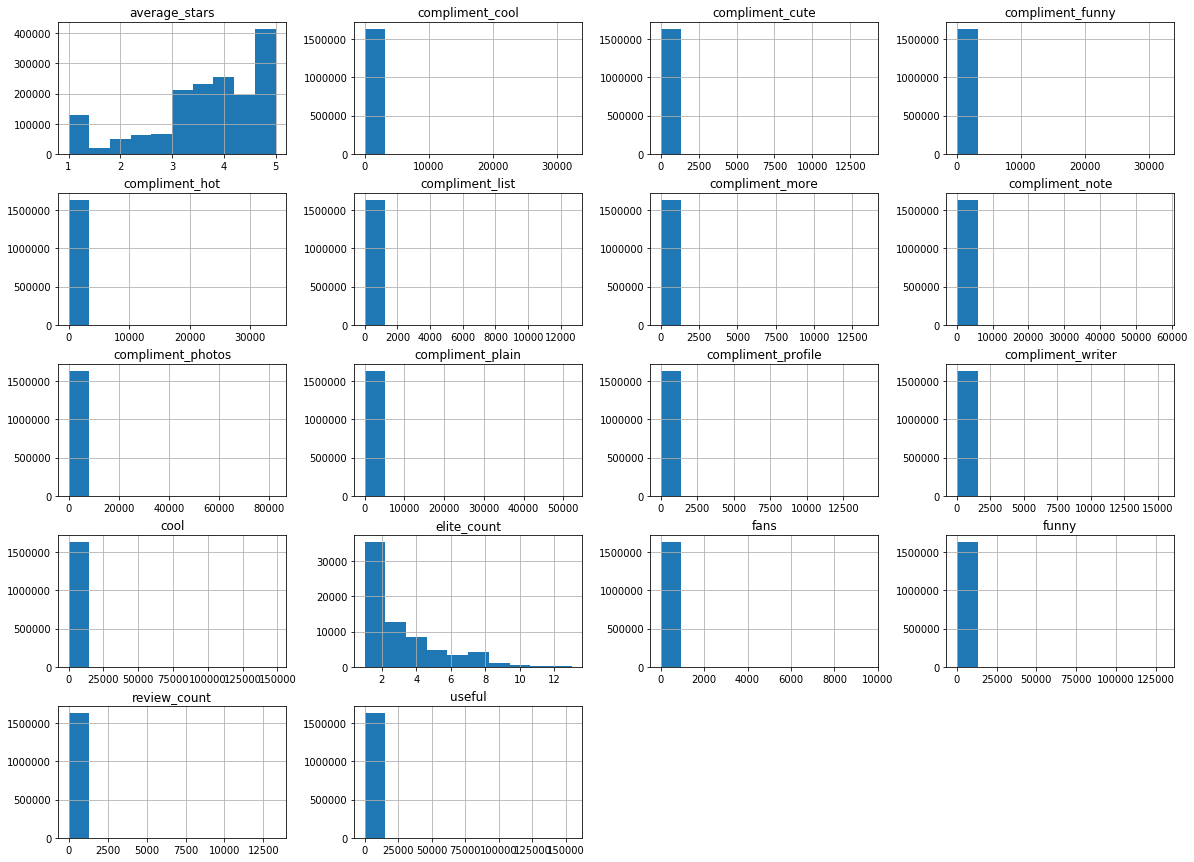

In [10]:
#numeric_fields = business_df_flat.select_dtypes(include=np.number).columns.tolist()
user_df_num = user_df.select_dtypes(include=np.number)
#for field in numeric_fields:

hist = user_df_num.hist()
#plt.xlim(-0,3000)
#Histograms don't really show much here because a lot of the fields are very close together with little spread.
#In addition, most values for these fields seem to be close to 0.
#However, it seems that elite_count is skewed to the right.

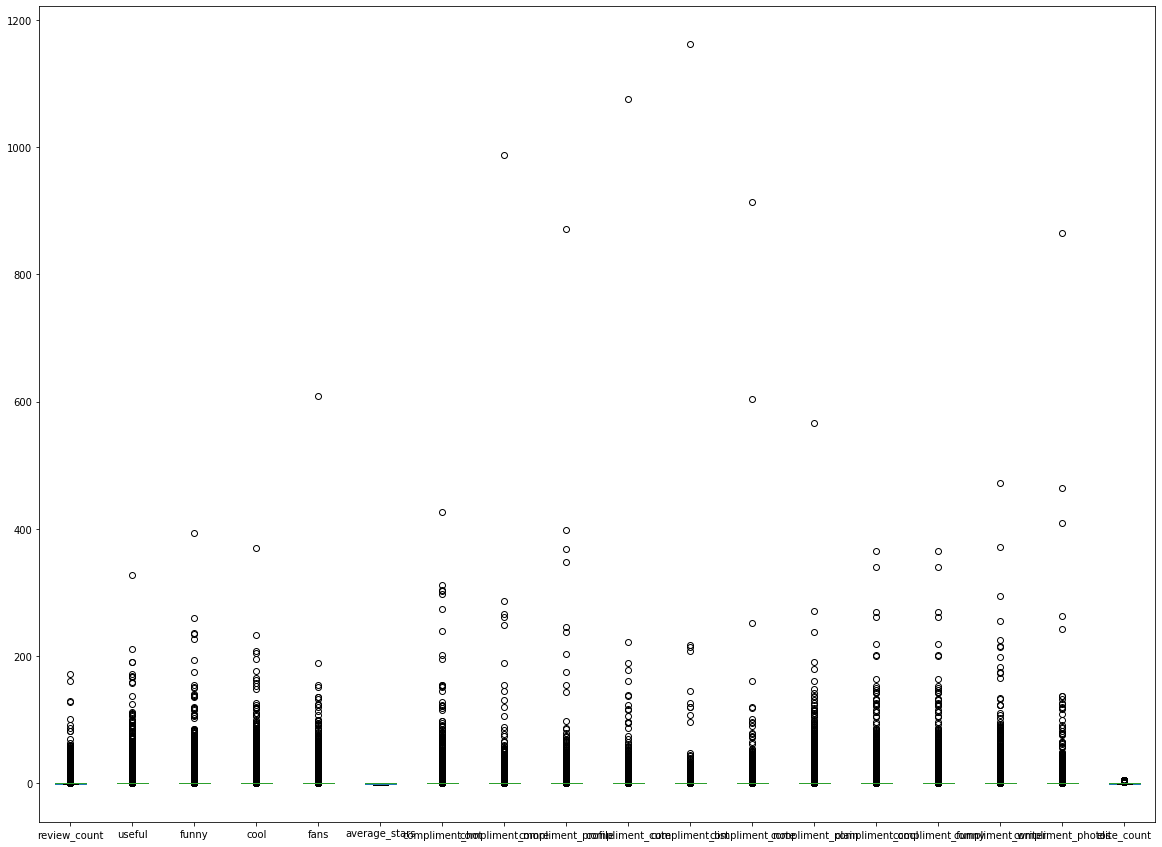

In [11]:
#Scale and center data to compare variance in side-by-side boxplots, and to easily spot outliers.
df_center = (user_df_num - user_df_num.mean())
df_scale = (df_center - df_center.mean())/df_center.std()
df_scale.plot.box()
#A lot of outlier and extremes. These will have to be treated prior to analysis.

In [12]:
#Clean up and save description csv.
#The plots can be obtained via screenshot.

#To make sure field names make it in output csv
row_labels = df_description_nulls.index.values
df_description_nulls.insert (0, "Field", row_labels)
df_to_csv(df_description_nulls, fp + "/user_desc_nulls", ext=".csv", na_rep="")

row_labels = df_description_number.index.values
df_description_number.insert (0, "Param", row_labels)
df_to_csv(df_description_number, fp + "/user_desc_number", ext=".csv", na_rep="")

row_labels = df_description_cat.index.values
df_description_cat.insert (0, "Param", row_labels)
df_to_csv(df_description_cat, fp + "/user_desc_cat", ext=".csv", na_rep="")


In [13]:
user_df = None
user_df_num = None
user_df_cat = None